# Predicting the movement of video game stocks using supervised learning

Here is a quick primer on the case for owning video game stocks:

- Highly profitable businesses
- Produce a product that is extremely sticky (read: addictive)
- Companies have a considerable moat due to the increasing cost in producing Triple AAA games
- Overall market expected to increase at an annual rate of about 5-6% until 2021.

Further to that, the  games that are produced by these companies are increasingly played in the public realm thanks in part to the advent of modern streaming platforms like Youtube and Twitch. The games also enjoy significant coverage and discussion in public forums like Twitter.

These stocks are one of the first, where the use of the companies product can be estimated, if not accurately tracked, in real time. I suspect that this offers an opportunity to make informed decisions on ownership and trading of these companies and further to this, probably impacts the price behavior of these stocks.

<img src="twitchtrends.png">
Fig 1: Games are increasingly being played and tracked online. This may be a lucrative trove for informed investors.

This capstone will focus on predicting the price action of video game stocks based on financial indictors.  Future iterations will aim to incorporate scrapped data from streaming sources and social media. Due to the provenance of large amounts of data in both of these domains, we will initially build a model on one indicator company and see if this model can be applied to other companies, first without reteaching based on that model and if required, with reteaching.

<h1><center> Companies of interest: </center></h1>

| Company     | Market Cap (in $, rounded) | Country of Origin         |
|-------------|----------------------------|---------------------------|
| EA          | 28 Billion                 | US                        |
| Take Two    | 11 Billion                 | US                        |
| Activision  | 36 Billion                 | US                        |
| Ubisoft     | 9 Billion                  | France/Operates worldwide |
| Square Enix | 4 Billion                  | Japan                     |
| Nintendo    | 45 Billion                 | Japan                     |
| Konami      | 7 Billion                  | Japan                     |
| Capcom      | 3 Billion                  | Japan                     |


From this list, Activision is a fairly representative company. So let's start by modelling and generating our features for this company. The features used will be consistent across all companies.

In [17]:
import pandas as pd
import numpy as np
current_state = np.random.get_state()
np.random.set_state(current_state)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from scipy import stats
from scipy.stats import ttest_ind
import time 
import random

from collections import Counter
from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, mean_squared_error, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from IPython.display import display
from sklearn.metrics import recall_score

from datetime import datetime
import plotly  as py
py.tools.set_credentials_file(username='mcmanusdatascience', api_key='Mkw1SmxGJj1HPglRqBES')
import plotly.graph_objs as go
import plotly.tools as tls


import warnings
warnings.filterwarnings("ignore")

import pandas_datareader.data as web
import datetime as dt
from datetime import date
import re

In [3]:
# Pull up to date data for the companies we're interested in
start = dt.datetime(2015,1,1)
end = date.today()

ATVI = pd.concat([web.DataReader('ATVI','yahoo', start, end)]).reset_index()
EA = pd.concat([web.DataReader('EA','yahoo', start, end)]).reset_index()
TT = pd.concat([web.DataReader('TTWO','yahoo', start, end)]).reset_index()
UBI = pd.concat([web.DataReader('UBSFY','yahoo', start, end)]).reset_index()
SE = pd.concat([web.DataReader('SQNXF','yahoo', start, end)]).reset_index()
NIN = pd.concat([web.DataReader('NTDOY','yahoo', start, end)]).reset_index()
KON = pd.concat([web.DataReader('KNMCY','yahoo', start, end)]).reset_index()
CC = pd.concat([web.DataReader('CCOEY','yahoo', start, end)]).reset_index()

Due to the asyynchronous loading method used on the site we're sourcing our streaming data from. We will scrape the data manually. It is possible to scrape this data automatically but it is bandwidth intensive and could cause issues given the size and scope of website we are utilizing.

To scrape the data found below, on the sullygnome.com site left click any graph, hit inspect, then network, then XHR. When the graph is refreshed, the data pulled that the graph references will be found in %20/ file. 


In [54]:
#quick functions to strip data out of json
def stripviewdata(df):
    return df.iloc[2,3]

def stripviewdate(df):
    return df.iloc[10,3]

In [ ]:
#write function to clean date data
def cleandate(column):
    column = column.astype(str)
    column = column.apply(lambda x: re.sub(" 00:00", "", x)).astype(str)
    return column.apply(pd.to_datetime)

# OW data for ATVI

In [6]:
#strip data out of the json files for the top ten blizzard activision games.
ow = pd.read_json('ow.json', orient='columns')
ow = ow.reset_index()
ow_data = ow.iloc[2, 3]
ow_time = ow.iloc[10, 3]    

In [12]:
#make pandas dataframe with the date of the top ten blizzard activision games
ow_timeseries = pd.DataFrame(data=ow_time)

In [23]:
#further clean viewer data
peak_viewers=ow_data[0]
average_viewers=ow_data[1]
#get peak viewers data as 1 column
ow_viewers_1 = pd.DataFrame(data=peak_viewers)
#get average viewers data as 1 column
ow_viewers_2 = pd.DataFrame(data=average_viewers)
ow_view_data = pd.DataFrame()
ow_view_data['average'] = ow_viewers_2['data']
ow_view_data['peak'] = ow_viewers_1['data']
ow_view_data['date'] = ow_timeseries[0]

In [24]:
#clean date data
ow_view_data['date'] = cleandate(ow_view_data['date'])

# COD4MW for ATVI

In [108]:
#load data for cod4mw
cod4mw = pd.read_json('cod4mw.json', orient='columns')
cod4mw = cod4mw.reset_index()
#strip data from json file
peak_viewers = (stripviewdata(cod4mw))[0]
average_viewers = (stripviewdata(cod4mw))[1]
cod4mw_date= stripviewdate(cod4mw)
#make pandas dataframe with the date of the top ten blizzard activision games
cod4mw_timeseries = pd.DataFrame(data=cod4mw_date)
#create new data frame with all data
cod4mw_view_data = pd.DataFrame()
cod4mw_view_data['peak'] = peak_viewers['data']
cod4mw_view_data['average'] = average_viewers['data']
cod4mw_view_data['date'] = cod4mw_timeseries[0]
#clean date data
cod4mw_view_data['date'] = cleandate(cod4mw_view_data['date'])

# codbo4 for ATVI

In [192]:
#load data for codbo4
codbo4 = pd.read_json('codbo4.json', orient='columns')
codbo4 = codbo4.reset_index()
#strip data from json file
peak_viewers = (stripviewdata(codbo4))[0]
average_viewers = (stripviewdata(codbo4))[1]
codbo4_date= stripviewdate(codbo4)
#make pandas dataframe with the date of the top ten blizzard activision games
codbo4_timeseries = pd.DataFrame(data=codbo4_date)
#create new data frame with all data
codbo4_view_data = pd.DataFrame()
codbo4_view_data['peak'] = peak_viewers['data']
codbo4_view_data['average'] = average_viewers['data']
codbo4_view_data['date'] = codbo4_timeseries[0]
#clean date data
codbo4_view_data['date'] = cleandate(codbo4_view_data['date'])

# Crash Team Racing/ATVI



In [202]:
#load data for ctr
ctr = pd.read_json('ctr.json', orient='columns')
ctr = ctr.reset_index()
#strip data from json file
peak_viewers = (stripviewdata(ctr))[0]
average_viewers = (stripviewdata(ctr))[1]
ctr_date= stripviewdate(ctr)
#make pandas dataframe with the date of the top ten blizzard activision games
ctr_timeseries = pd.DataFrame(data=ctr_date)
#create new data frame with all data
ctr_view_data = pd.DataFrame()
ctr_view_data['peak'] = peak_viewers['data']
ctr_view_data['average'] = average_viewers['data']
ctr_view_data['date'] = ctr_timeseries[0]
#clean date data
ctr_view_data['date'] = cleandate(ctr_view_data['date'])

# heros of the storm/atvi

In [121]:
#load data for hos
hos = pd.read_json('hos.json', orient='columns')
hos = hos.reset_index()
#strip data from json file
peak_viewers = (stripviewdata(hos))[0]
average_viewers = (stripviewdata(hos))[1]
hos_date= stripviewdate(hos)
#make pandas dataframe with the date of the top ten blizzard activision games
hos_timeseries = pd.DataFrame(data=hos_date)
#create new data frame with all data
hos_view_data = pd.DataFrame()
hos_view_data['peak'] = peak_viewers['data']
hos_view_data['average'] = average_viewers['data']
hos_view_data['date'] = hos_timeseries[0]
#clean date data
hos_view_data['date'] = cleandate(hos_view_data['date'])

# hearthstone/atvi

In [122]:
#load data for hs
hs = pd.read_json('hs.json', orient='columns')
hs = hs.reset_index()
#strip data from json file
peak_viewers = (stripviewdata(hs))[0]
average_viewers = (stripviewdata(hs))[1]
hs_date= stripviewdate(hs)
#make pandas dataframe with the date of the top ten blizzard activision games
hs_timeseries = pd.DataFrame(data=hs_date)
#create new data frame with all data
hs_view_data = pd.DataFrame()
hs_view_data['peak'] = peak_viewers['data']
hs_view_data['average'] = average_viewers['data']
hs_view_data['date'] = hs_timeseries[0]
#clean date data
hs_view_data['date'] = cleandate(hs_view_data['date'])

# starcraft 1 and 2/atvi

In [123]:
#load data for sc
sc = pd.read_json('sc.json', orient='columns')
sc = sc.reset_index()
#strip data from json file
peak_viewers = (stripviewdata(sc))[0]
average_viewers = (stripviewdata(sc))[1]
sc_date= stripviewdate(sc)
#make pandas dataframe with the date of the top ten blizzard activision games
sc_timeseries = pd.DataFrame(data=sc_date)
#create new data frame with all data
sc_view_data = pd.DataFrame()
sc_view_data['peak'] = peak_viewers['data']
sc_view_data['average'] = average_viewers['data']
sc_view_data['date'] = sc_timeseries[0]
#clean date data
sc_view_data['date'] = cleandate(sc_view_data['date'])


#load data for sc2
sc2 = pd.read_json('sc2.json', orient='columns')
sc2 = sc2.reset_index()
#strip data from json file
peak_viewers = (stripviewdata(sc2))[0]
average_viewers = (stripviewdata(sc2))[1]
sc2_date= stripviewdate(sc2)
#make pandas dataframe with the date of the top ten blizzard activision games
sc2_timeseries = pd.DataFrame(data=sc2_date)
#create new data frame with all data
sc2_view_data = pd.DataFrame()
sc2_view_data['peak'] = peak_viewers['data']
sc2_view_data['average'] = average_viewers['data']
sc2_view_data['date'] = sc2_timeseries[0]
#clean date data
sc2_view_data['date'] = cleandate(sc2_view_data['date'])

# sekiro/atvi

In [315]:
#load data for sekiro
sekiro = pd.read_json('sekiro.json', orient='columns')
sekiro = sekiro.reset_index()
#strip data from json file
peak_viewers = (stripviewdata(sekiro))[0]
average_viewers = (stripviewdata(sekiro))[1]
sekiro_date= stripviewdate(sekiro)
#make pandas dataframe with the date of the top ten blizzard activision games
sekiro_timeseries = pd.DataFrame(data=sekiro_date)
#create new data frame with all data
sekiro_view_data = pd.DataFrame()
sekiro_view_data['peak'] = peak_viewers['data']
sekiro_view_data['average'] = average_viewers['data']
sekiro_view_data['date'] = sekiro_timeseries[0]
#clean date data
sekiro_view_data['date'] = cleandate(sekiro_view_data['date'])

# wow/atvi

In [153]:
#load data for wow
wow = pd.read_json('wow.json', orient='columns')
wow = wow.reset_index()
#strip data from json file
peak_viewers = (stripviewdata(wow))[0]
average_viewers = (stripviewdata(wow))[1]
wow_date= stripviewdate(wow)
#make pandas dataframe with the date of the top ten blizzard activision games
wow_timeseries = pd.DataFrame(data=wow_date)
#create new data frame with all data
wow_view_data = pd.DataFrame()
wow_view_data['peak'] = peak_viewers['data']
wow_view_data['average'] = average_viewers['data']
wow_view_data['date'] = wow_timeseries[0]
#clean date data
wow_view_data['date'] = cleandate(wow_view_data['date'])

# diablo/atvi

In [124]:
#load data for diablo
diablo = pd.read_json('diablo.json', orient='columns')
diablo = diablo.reset_index()
#strip data from json file
peak_viewers = (stripviewdata(diablo))[0]
average_viewers = (stripviewdata(diablo))[1]
diablo_date= stripviewdate(diablo)
#make pandas dataframe with the date of the top ten blizzard activision games
diablo_timeseries = pd.DataFrame(data=diablo_date)
#create new data frame with all data
diablo_view_data = pd.DataFrame()
diablo_view_data['peak'] = peak_viewers['data']
diablo_view_data['average'] = average_viewers['data']
diablo_view_data['date'] = diablo_timeseries[0]
#clean date data
diablo_view_data['date'] = cleandate(diablo_view_data['date'])

In [316]:
# set index as date for all dataframes
diablo_view_data.index = diablo_view_data.date
wow_view_data.index = wow_view_data.date
sc_view_data.index = sc_view_data.date
sc2_view_data.index = sc2_view_data.date
sekiro_view_data.index = sekiro_view_data.date
hos_view_data.index = hos_view_data.date
hs_view_data.index = hs_view_data.date
ctr_view_data.index = ctr_view_data.date
codbo4_view_data.index = codbo4_view_data.date
cod4mw_view_data.index = cod4mw_view_data.date
ow_view_data.index = ow_view_data.date

In [161]:
diablo_view_data.index 

DatetimeIndex(['2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03',
               '2015-09-04', '2015-09-05', '2015-09-06', '2015-09-07',
               '2015-09-08', '2015-09-09',
               ...
               '2019-06-20', '2019-06-21', '2019-06-22', '2019-06-23',
               '2019-06-24', '2019-06-25', '2019-06-26', '2019-06-27',
               '2019-06-28', '2019-06-29'],
              dtype='datetime64[ns]', name='date', length=1399, freq=None)

In [317]:
#set cut off point so data frames match
df1 = diablo_view_data.loc['2015-09-17':]
df2 = wow_view_data.loc['2015-09-17':]
df3 = sc_view_data.loc['2015-09-17':]
df4= sc2_view_data.loc['2015-09-17':]
df5= sekiro_view_data.loc['2015-09-17':]
df6= hos_view_data.loc['2015-09-17':]
df7= hs_view_data.loc['2015-09-17':]
#removing crash team racing data from analysis due to lack of data..
#df8= ctr_view_data.loc['2015-09-17':]
df9= codbo4_view_data.loc['2015-09-17':]
df10= cod4mw_view_data.loc['2015-09-17':]
df11= ow_view_data.loc['2015-09-17':]

#replace nan with 0
df1.fillna(value=0)
df2.fillna(value=0)
df3.fillna(value=0)
df4.fillna(value=0)
df5.fillna(value=0)
df6.fillna(value=0)
df7.fillna(value=0)
df9.fillna(value=0)
df10.fillna(value=0)
df11.fillna(value=0)

,average,peak,date
date,,,
2015-09-17,0.0,9.0,2015-09-17
2015-09-18,1.0,10.0,2015-09-18
2015-09-19,1.0,9.0,2015-09-19
2015-09-20,1.0,7.0,2015-09-20
2015-09-21,3.0,26.0,2015-09-21
2015-09-22,1.0,7.0,2015-09-22
2015-09-23,2.0,21.0,2015-09-23
2015-09-24,2.0,16.0,2015-09-24
2015-09-25,0.0,6.0,2015-09-25


In [319]:
#df5 and df9 do not include a full set of data and we cannot add these to the total views as currently formatted
#let's add the full 
df5_start = pd.date_range(start='2015-09-17', end='2019-01-17')
df9_start = pd.date_range(start='2015-09-17', end='2018-07-04')
#make dataframe to be concatonated
concatdf5 = pd.DataFrame(index=df5_start)
concatdf9 = pd.DataFrame(index=df9_start)
#insert rows as 0
for row in concatdf5.index:
    concatdf5['average'] = 0
for row in concatdf9.index:
    concatdf9['average'] = 0
for row in concatdf5:
    concatdf5['peak'] = 0
for row in concatdf9:
    concatdf9['peak'] = 0   

In [322]:
#don't do this twice or you'll make a huge mess
#df5 = pd.concat([concatdf5, df5])
#df9 = pd.concat([concatdf9, df9])

In [324]:
# make a dataframe that includes all of the atvi views for the past 4 years
atvi_views = pd.DataFrame()

atvi_views['average'] = df1['average'] + df2['average'] + df3['average'] + df4['average']+ df5['average']  + df6['average'] + df7['average'] + df9['average']+ df10['average'] + df11['average']
atvi_views['peak'] = df1['peak'] + df2['peak'] + df3['peak'] + df4['peak']+ df5['peak']  + df6['peak'] + df7['peak'] + df9['peak']+ df10['peak'] + df11['peak']

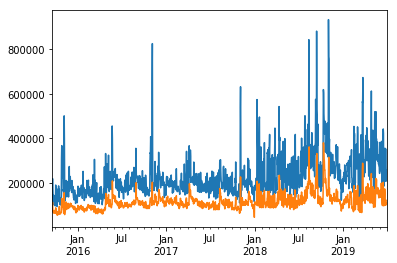

In [327]:
atvi_views['peak'].plot()
atvi_views['average'].plot()

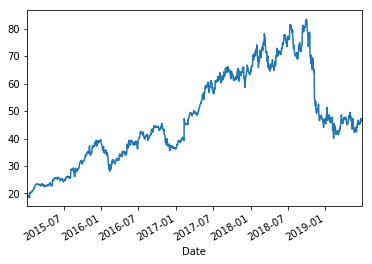

In [295]:
ATVI.Close.plot()

Looks good let's select a defined date range for both and then export the data:

In [328]:
ATVI_ranged = ATVI.loc['2015-09-17':'2019-06-26']
atvi_views_ranged = atvi_views.loc['2015-09-17':'2019-06-26']

In [339]:
ATVI_ranged.to_csv (r'C:\Users\Sean\Documents\Thinkful\Video Game Stocks Data\csv\ATVI.csv', index = None, header=True)
atvi_views_ranged.to_csv (r'C:\Users\Sean\Documents\Thinkful\Video Game Stocks Data\csv\ATVI_views.csv', index = None, header=True)